In [1]:
from ultralytics import YOLO
from roboflow import Roboflow

import torch
import wandb

from matplotlib import pyplot as plt
import seaborn as sns
from PIL import Image

import numpy as np
import pandas as pd
import os, dotenv, pathlib
dotenv.load_dotenv()

from collections import defaultdict
from scipy.spatial.distance import cdist

# <p align='center' style='color: #6c89c6;'>Работу выполнил: Таратин Артём ПМ22-1</p>

## Обучение

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
model = YOLO('yolov8m.pt').to(device)
model.info()

YOLOv8m summary: 295 layers, 25902640 parameters, 0 gradients, 79.3 GFLOPs


(295, 25902640, 0, 79.3204224)

In [4]:
mp = 7/8
imgsz = [int(i * mp) for i in (1280, 960)]
# imgsz = (960, 960)
imgsz

[1120, 840]

In [5]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kekwak. Use `wandb login --relogin` to force relogin


True

In [6]:
version = 10
rf = Roboflow(api_key=os.getenv('roboflow_api'))
project = rf.workspace('mr-pony').project('basil-kktu5')
dataset = project.version(version).download('yolov8')

loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.2.45, to fix: `pip install ultralytics==8.0.196`


In [7]:
best_hyp_40 = {
    'lr0': 0.00314,
    'lrf': 0.01338,
    'momentum': 0.89095,
    'weight_decay': 0.00032,
    'warmup_epochs': 3.19081,
    'warmup_momentum': 0.84131,
    'box': 6.84945,
    'cls': 0.25861,
    'dfl': 1.04785,
    'hsv_h': 0.01576,
    'hsv_s': 0.77064,
    'hsv_v': 0.34917,
    'degrees': 0.0,
    'translate': 0.06697,
    'scale': 0.23545,
    'shear': 0.0,
    'perspective': 0.0,
    'flipud': 0.0,
    'fliplr': 0.65056,
    'bgr': 0.0,
    'mosaic': 0.96474,
    'mixup': 0.0,
    'copy_paste': 0.0,
}

In [ ]:
results = model.train(
    name='yolov8_NII',
    # project='YOLO_NII',
    data='data.yaml',
    imgsz=imgsz,
    epochs=85,
    seed=42,

    **best_hyp_40,
)

In [ ]:
results.results_dict

In [8]:
model = YOLO('./runs/detect/yolov8_NII3/weights/best.pt').to(device)

In [9]:
metrics = model.val()  # conf=0.0.57
pd.DataFrame(metrics.results_dict.items(), columns=['metrics', 'value'])

Model summary (fused): 218 layers, 25840918 parameters, 0 gradients, 78.7 GFLOPs


val: Scanning /home/kekwak/Рабочий стол/НИИ/yolo/basil-10/valid/labels.cache... 14 images, 0 backgrounds, 0 corrupt: 100%|██████████| 14/14 [00:00<?, ?it/s]

val: WARNING ⚠️ /home/kekwak/Рабочий стол/НИИ/yolo/basil-10/valid/images/PS-V2ver-L6-sch36_jpg.rf.af2934bcfeb0da2e16e2abf603543c29.jpg: 1 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


                   all         14        388      0.821       0.84      0.888      0.701
                 Empty         14        184      0.774       0.88       0.87      0.663
                  Full         14        204      0.867        0.8      0.906       0.74
Speed: 0.4ms preprocess, 16.4ms inference, 0.0ms loss, 20.7ms postprocess per image
Results saved to runs/detect/val


,metrics,value
0,metrics/precision(B),0.820803
1,metrics/recall(B),0.840205
2,metrics/mAP50(B),0.887884
3,metrics/mAP50-95(B),0.701093
4,fitness,0.719772


In [10]:
metrics = model.val(conf=0.57)  # conf=0.0.57
pd.DataFrame(metrics.results_dict.items(), columns=['metrics', 'value'])

val: Scanning /home/kekwak/Рабочий стол/НИИ/yolo/basil-10/valid/labels.cache... 14 images, 0 backgrounds, 0 corrupt: 100%|██████████| 14/14 [00:00<?, ?it/s]

val: WARNING ⚠️ /home/kekwak/Рабочий стол/НИИ/yolo/basil-10/valid/images/PS-V2ver-L6-sch36_jpg.rf.af2934bcfeb0da2e16e2abf603543c29.jpg: 1 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


                   all         14        388      0.848      0.796      0.844      0.693
                 Empty         14        184      0.806      0.837      0.835      0.656
                  Full         14        204       0.89      0.755      0.853       0.73
Speed: 1.9ms preprocess, 9.7ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/val2


,metrics,value
0,metrics/precision(B),0.848228
1,metrics/recall(B),0.795929
2,metrics/mAP50(B),0.844136
3,metrics/mAP50-95(B),0.692903
4,fitness,0.708026


In [11]:
def draw_results(result, img, txt_file, colors):
    txt = txt_file.copy()
    
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(30, 22))

    w, h = img.size
    txt[['xc', 'w']] = txt[['xc', 'w']] * w
    txt[['yc', 'h']] = txt[['yc', 'h']] * h

    ax[0, 0].set_title('Исходное изображение')
    ax[0, 0].imshow(img)

    ax[0, 1].set_title('Ошибки модели')
    ax[0, 1].imshow(img)

    ax[1, 0].set_title('Разметка')
    ax[1, 0].imshow(img)

    ax[1, 1].set_title('Предсказание')
    ax[1, 1].imshow(img)
    
    for cl, x0, y0, w, h in txt.to_numpy():
        ax[1, 0].add_patch(plt.Rectangle((x0-w//2, y0-h//2), w, h, fill=False, color=colors[int(cl)]))
        ax[1, 0].text(x0-w//2, y0-h//2, f'{result.names[cl]}', color='white', fontsize=12)
    
    coordinates = np.concatenate(
        [
            result.boxes.xyxy.cpu(),
            result.boxes.conf.cpu()[:, np.newaxis],
            result.boxes.cls.cpu()[:, np.newaxis]
        ], axis=1)
    for x1, y1, x2, y2, conf, cl in coordinates:
        ax[1, 1].add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, color=colors[int(cl)]))
        ax[1, 1].text(x1, y1, f'{result.names[cl]} {conf*100:.0f}%', color='white', fontsize=12)
    
    pred_cls = result.boxes.cls.cpu()
    true_cls = txt['cl']
    true_boxes = np.array([[x0-w//2, y0-h//2, x0+w//2, y0+h//2] for cl, x0, y0, w, h in txt.to_numpy()])

    for i, (x1, y1, x2, y2, conf, cl) in enumerate(coordinates):
        if not any((pred_cls[i] == true_cls[j]) and (np.allclose([x1, y1, x2, y2], true_boxes[j], atol=20)) for j in range(len(true_cls))):
            ax[0, 1].add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, color='orange'))
            ax[0, 1].text(x1, y1, f'Pred: {result.names[pred_cls[i].int().item()]}', color='white', fontsize=12)

    fig.tight_layout()
    plt.show()

In [12]:
img_base = pathlib.Path(f'./{dataset.name}-{dataset.version}/valid/images/')
txt_base = img_base.parent / './labels/'

img_file = np.random.choice(list(img_base.iterdir()))
txt_file = txt_base / f'{img_file.stem}.txt'

img = Image.open(img_file)
txt = pd.read_csv(txt_file, sep=' ', index_col=None, names=['cl', 'xc', 'yc', 'w', 'h'])
print(img_file, txt_file, sep='\n')

basil-10/valid/images/Vs-5-2niz-sch3ax100-952_jpg.rf.5f6f788f1393523c7c6a9007a04f8b36.jpg
basil-10/valid/labels/Vs-5-2niz-sch3ax100-952_jpg.rf.5f6f788f1393523c7c6a9007a04f8b36.txt


In [13]:
out = model(img, conf=0.5)[0]  # conf=0.5
colors = [(1, 0, 0), (0, 1, 0)]
draw_results(out, img, txt, colors)


0: 864x1120 9 Emptys, 15 Fulls, 87.9ms
Speed: 5.5ms preprocess, 87.9ms inference, 1.1ms postprocess per image at shape (1, 3, 864, 1120)


<Figure size 3000x2200 with 4 Axes>


0: 864x1120 4 Emptys, 20 Fulls, 7.8ms
Speed: 5.1ms preprocess, 7.8ms inference, 0.8ms postprocess per image at shape (1, 3, 864, 1120)


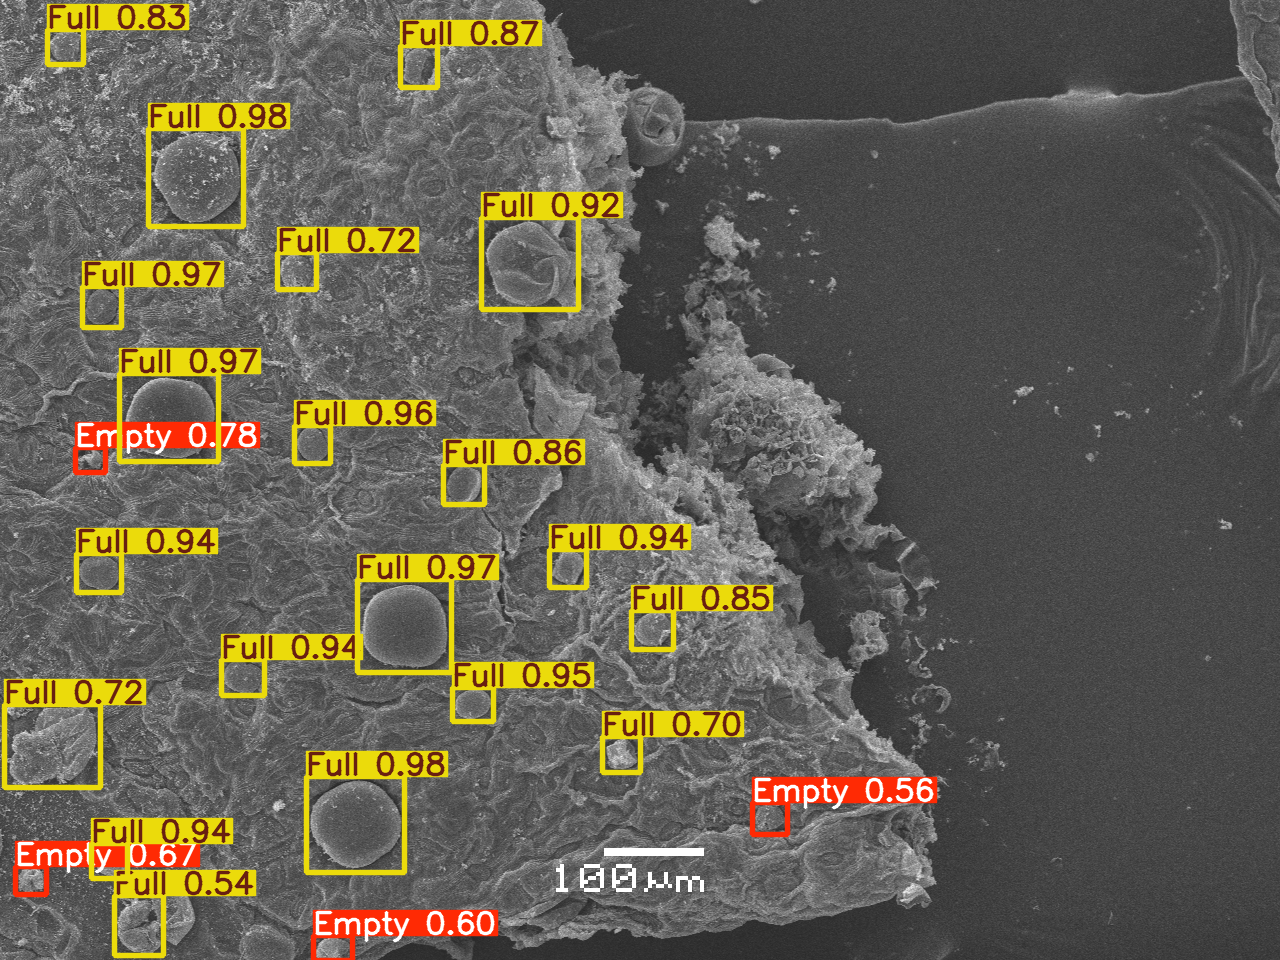

In [14]:
img_test = Image.open('./../Железки/Четвертая партия 2024-07-10/QS-5-Fragm6-nizh-e.tif')
out = model(img_test, conf=0.5)[0]  # conf=0.5, iou=1.0
Image.fromarray(out.plot())

In [15]:
detections = out.boxes.xyxy.cpu().numpy()
detections_xywh = out.boxes.xywh.cpu().numpy()
box_class = out.boxes.cls.cpu().numpy()
id2label = out.names

In [16]:
def get_class_coords(detections, box_class, id2label):
    class_coords = defaultdict(list)
    for det, box_cls in zip(detections, box_class):
        x1, y1, x2, y2 = det
        center_x, center_y = (x1 + x2) / 2, (y1 + y2) / 2
        class_coords[id2label[int(box_cls)]].append((center_x, center_y))
    return class_coords

def nearest_neighbor_distances(coords):
    if len(coords) <= 1:
        return [np.inf]
    distances = cdist(coords, coords)
    np.fill_diagonal(distances, np.inf)
    return distances.min(axis=1)

def get_distances(detections, box_class, id2label):
    class_coords = get_class_coords(detections, box_class, id2label)
    all_distances, average_distances = {}, {}
    for class_id, coords in class_coords.items():
        distances = nearest_neighbor_distances(coords)
        all_distances[class_id] = distances
        average_distances[class_id] = np.mean(distances)
    return all_distances, average_distances

def get_radius(detections_xywh, box_class, id2label):
    all_radius, average_radius = {}, {}
    radius = detections_xywh[:, 2:].mean(axis=1) / 2
    for k,v in id2label.items():
        curr_radius = radius[box_class == k]
        all_radius[v] = curr_radius
        average_radius[v] = curr_radius.mean()
    return all_radius, average_radius

def get_square(detections_xywh, box_class, id2label):
    all_square, average_square = {}, {}
    a, b = detections_xywh[:, 2:].T / 2
    square = a * b * np.pi
    for k,v in id2label.items():
        curr_radius = square[box_class == k]
        all_square[v] = curr_radius
        average_square[v] = curr_radius.mean()
    return all_square, average_square

def get_share(box_class, id2label):
    share = {}
    for k,v in id2label.items():
        share[v] = round((box_class == k).sum() / box_class.shape[0] * 100, 4)
    return share

In [17]:
all_distances, average_distances = get_distances(detections, box_class, id2label)
all_radius, average_radius = get_radius(detections_xywh, box_class, id2label)
all_square, average_square = get_square(detections_xywh, box_class, id2label)
count_share = get_share(box_class, id2label)

In [18]:
print('Средние расстояния до ближайших соседей по классам:', average_distances)
print('Средние значения радиуса по классам:', average_radius)
print('Средние значения площади по классам:', average_square)
print('Доля трихом по классам:', count_share)

Средние расстояния до ближайших соседей по классам: {'Full': 138.70246414033403, 'Empty': 374.8400453545839}
Средние значения радиуса по классам: {'Empty': 15.326178, 'Full': 27.981058}
Средние значения площади по классам: {'Empty': 728.77234, 'Full': 2957.2622}
Доля трихом по классам: {'Empty': 16.6667, 'Full': 83.3333}


In [19]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
palette={'Full':'#94b9ff', 'Empty':'#de3e35'}

ax[0, 0].set_title('Распределение расстояний до ближайших соседей')
sns.histplot(all_distances, ax=ax[0, 0], palette=palette)

ax[0, 1].set_title('Распределение значений площади')
sns.histplot(all_square, ax=ax[0, 1], palette=palette)

ax[0, 2].set_title('Распределение значений радиуса')
sns.histplot(all_radius, ax=ax[0, 2], palette=palette)

ax[1, 2].set_title('Доля трихом')
sns.barplot(count_share, ax=ax[1, 2], palette=palette)

ax[1, 0].set_title('Распределение расстояний до ближайших соседей')
sns.barplot(all_distances, ax=ax[1, 0], palette=palette)

ax[1, 1].set_title('Распределение значений площади')
sns.barplot(all_square, ax=ax[1, 1], palette=palette)

plt.tight_layout()
plt.show()



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



<Figure size 2000x1000 with 6 Axes>

## Прогонка предыдущих партий

In [ ]:
def return_img_paths(img_base):
    return list(filter(lambda x: '.txt' not in str(x) and '.db' not in str(x), img_base.iterdir()))

def save_results(output, img_paths, output_dir):
    output_dir.mkdir(parents=True, exist_ok=True)
    for img_path, result in zip(img_paths, output):
        result.save(output_dir / img_path.name)

In [ ]:
img_base_first_step = pathlib.Path('./../Железки/Первая партия - Базилик Железки Общее/')
img_base_second_step = pathlib.Path('./../Железки/Вторая партия 2024-02-16-Ocimum/')
img_base_first_step.exists(), img_base_second_step.exists()

In [ ]:
img_paths_first_step = return_img_paths(img_base_first_step)
img_paths_second_step = return_img_paths(img_base_second_step)

In [ ]:
out_first_step = model(img_paths_first_step)
out_second_step = model(img_paths_second_step)

In [ ]:
output_dir_first_step = pathlib.Path('./results/Первая партия - Базилик Железки Общее/')
output_dir_second_step = pathlib.Path('./results/Вторая партия 2024-02-16-Ocimum/')

save_results(out_first_step, img_paths_first_step, output_dir_first_step)
save_results(out_second_step, img_paths_second_step, output_dir_second_step)